# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install pydicom
!pip3 install segmentation_models

     |████████████████████████████████| 1.9MB 5.5MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import csv
import pickle
import pydicom
import gc
import numpy as np
import pandas as pd 
from glob import glob
import albumentations as A
import keras
import tensorflow as tf
from keras import backend as K

os.chdir('/content/drive/MyDrive/Initial-Code')

from preprocess_dataset import prepare_data
from iou_dice_loss_functions import my_iou_metric, iou_metric_batch_val, bce_dice_loss
%env SM_FRAMEWORK=tf.keras

from model_rle_functions import predict_result_val, prepare_test, get_test, get_prediction, get_rles
from data_generator_functions import data_generator, label_generator

import seg_models
keras.backend.set_image_data_format('channels_last')

from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

import sys

seed = 1994
np.random.seed = seed
os.environ['PYTHONHASHSEED'] = str(seed)
tf.seed = seed

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
Segmentation Models: using `tf.keras` framework.


In [4]:
!pip3 install backbone-network

  Created wheel for backbone-network: filename=backbone_network-1.1.2-cp37-none-any.whl size=3660 sha256=15305cdf43738b02db755740e211e31024b47490decd0917e012b7684903d0d4
  Stored in directory: /root/.cache/pip/wheels/2c/ce/78/5003d0c494f645b3d753cabe0e7a78cd58835e99408cf32c1f
Successfully built backbone-network


# Dataset

In [5]:
# defining configuration parameters
org_size = 1024   # original image size
img_size = 256    # image resize size
batch_size = 64    # batch size for training unet

## Load train and validation data from files

In [6]:
pkl_file_train = open('process_data/X_train.pkl', 'rb')

X_train = pickle.load(pkl_file_train)

In [7]:
pkl_file_val = open('process_data/X_val.pkl', 'rb')

X_val = pickle.load(pkl_file_val)

In [8]:
pkl_file_masks = open('process_data/masks.pkl', 'rb')

masks = pickle.load(pkl_file_masks)

## Data generation & Augmentations

In [9]:

training_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        #A.CLAHE(),
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
         ], p=0.3),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20,
                                        interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, p=1),
    A.RandomSizedCrop(min_max_height=(206,256), height=img_size, width=img_size,p=0.25)
],p=1)

In [10]:
params_train = {'img_size': img_size,
          'batch_size': batch_size,
          'n_channels': 3,
          'shuffle': True,
           'augmentations':training_augmentation,
           }

params_val = {'img_size': img_size,
          'batch_size': batch_size,
          'n_channels': 3,
          'shuffle': True,
         }

# Generators
training_generator = data_generator(X_train, masks, **params_train)
validation_generator = data_generator(X_val, masks, **params_val)

In [11]:
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)

(64, 256, 256, 3) (64, 256, 256, 1)


# Segmentation model

In [12]:
K.clear_session()

In [13]:
BACKBONE = 'resnet34'
model = seg_models.Unet(backbone_name=BACKBONE, encoder_weights='imagenet') #, decoder_use_batchnorm=False)
model.summary()

85524480/85521592 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [14]:
opt = SGD(momentum=0.9)

In [15]:
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[my_iou_metric])

In [17]:
from swa import SWA
from annealing_scheduler_function import CosineAnnealingScheduler

In [ ]:
epochs = 100
swa = SWA('model_output/256_resnet34_swa_stage1_exp5.model',95)

callbacks = [
    ModelCheckpoint("model_output/256_resnet34_stage1_exp5.model",monitor='val_loss', 
                            mode = 'min', save_best_only=True,
                            verbose=1),
    swa,
    CosineAnnealingScheduler(T_max=epochs, eta_max=1e-3, eta_min=1e-5, verbose=1)
]

In [ ]:
history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,   
                           epochs=epochs, verbose=1,
                            callbacks=callbacks)

In [ ]:
# list all data in history
import matplotlib.pyplot as plt
 
print(history.history.keys())

# summarize history for iou
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'])
plt.plot(history.history['val_my_iou_metric'])
plt.title('model IOU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
# Load best model or swa model

model.load_weights('model_output/256_resnet34_swa_stage1_exp5.model')

In [ ]:
# defining configuration parameters
org_size = 1024 # original image size
img_size = 512# image resize size
batch_size = 16 # batch size for training unet

In [ ]:
pkl_file_train = open('process_data/X_train.pkl', 'rb')

X_train = pickle.load(pkl_file_train)

In [ ]:
pkl_file_val = open('process_data/X_val.pkl', 'rb')

X_val = pickle.load(pkl_file_val)

In [ ]:
pkl_file_masks = open('process_data/masks.pkl', 'rb')

masks = pickle.load(pkl_file_masks)

In [ ]:
import albumentations as A

In [ ]:
training_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        #A.CLAHE(),
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
         ], p=0.3),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20,
                                        interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, p=1),
    A.RandomSizedCrop(min_max_height=(412, 512), height=img_size, width=img_size,p=0.25)
],p=1)

In [ ]:
params_train = {'img_size': img_size,
          'batch_size': batch_size,
          'n_channels': 3,
          'shuffle': True,
           'augmentations':training_augmentation,
           }

params_val = {'img_size': img_size,
          'batch_size': batch_size,
          'n_channels': 3,
          'shuffle': True,
         }

# Generators
training_generator = data_generator(X_train, masks, **params_train)
validation_generator = data_generator(X_val, masks, **params_val)

In [ ]:
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)

(16, 512, 512, 3) (16, 512, 512, 1)


In [ ]:
from swa import SWA
from annealing_scheduler_function import CosineAnnealingScheduler

In [ ]:
epochs = 70
swa = SWA('model_output/512_resnet34_swa_stage2_exp5.model',55)

callbacks = [
    ModelCheckpoint("model_output/512_resnet34_stage2_exp5.model",monitor='val_loss', 
                            mode = 'min', save_best_only=True,
                            verbose=1),
    swa,
    CosineAnnealingScheduler(T_max=epochs, eta_max=1e-3, eta_min=1e-5, verbose=1)
]

In [ ]:
history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,   
                           epochs=epochs, verbose=1,
                            callbacks=callbacks) 

Stochastic weight averaging selected for last 15 epochs.
Epoch 1/70

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.001.
562/562 [==============================] - 6346s 11s/step - loss: 1.0643 - my_iou_metric: 0.6892 - val_loss: 1.0221 - val_my_iou_metric: 0.8034

Epoch 00001: val_loss improved from inf to 1.02210, saving model to model_output/512_resnet34_stage2_exp5.model
INFO:tensorflow:Assets written to: model_output/512_resnet34_stage2_exp5.model/assets
Epoch 2/70

Epoch 00002: CosineAnnealingScheduler setting learning rate to 0.0009995015679379509.
562/562 [==============================] - 515s 915ms/step - loss: 0.9988 - my_iou_metric: 0.7846 - val_loss: 0.9558 - val_my_iou_metric: 0.8024

Epoch 00002: val_loss improved from 1.02210 to 0.95584, saving model to model_output/512_resnet34_stage2_exp5.model
INFO:tensorflow:Assets written to: model_output/512_resnet34_stage2_exp5.model/assets
Epoch 3/70

Epoch 00003: CosineAnnealingScheduler setting learning rate 

dict_keys(['loss', 'my_iou_metric', 'val_loss', 'val_my_iou_metric', 'lr'])


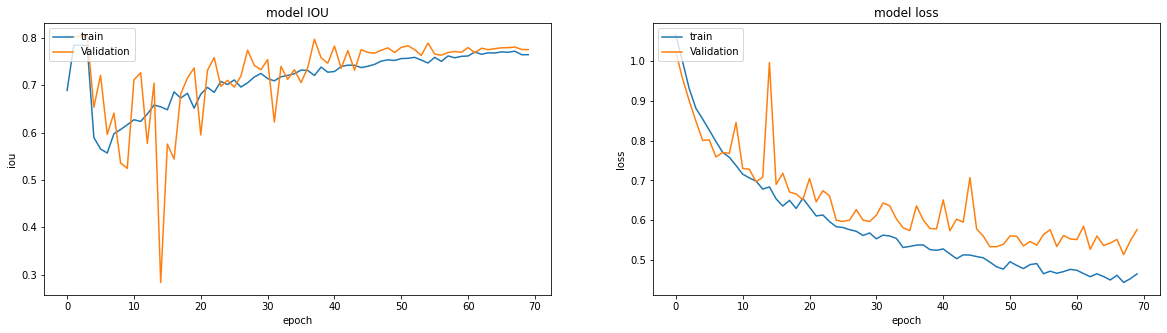

In [ ]:
# list all data in history
import matplotlib.pyplot as plt
 
print(history.history.keys())

# summarize history for iou
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'])
plt.plot(history.history['val_my_iou_metric'])
plt.title('model IOU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

# Evaluation validation data

In [ ]:
# Load best model or swa model

model.load_weights('model_output/256_resnet34_swa_stage1_exp5.model')

In [ ]:
params_val = {'img_size': img_size,
          'batch_size': 5,
          'n_channels': 3,
          'shuffle': False,
         }

# Generators
validation_generator = data_generator(X_val, masks, **params_val)

In [ ]:
AUGMENTATIONS_TEST_FLIPPED = A.Compose([
    A.HorizontalFlip(p=1),
],p=1)

params_val_flip = {'img_size': img_size,
          'batch_size': 5,
          'n_channels': 3,
          'shuffle': False,
        'augmentations':AUGMENTATIONS_TEST_FLIPPED,
         }

validation_generator_flipped = data_generator(X_val, masks, **params_val_flip)

In [ ]:
preds_valid_orig = predict_result_val(model,validation_generator,img_size)
preds_valid_flipped = predict_result_val(model,validation_generator_flipped,img_size)
preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped

In [ ]:
np.savez_compressed('process_data/val_pre/preds_valid_resnet34', array1= preds_valid)

In [ ]:
y_truth_val = label_generator(X_val, masks, len(preds_valid), img_size, 3)

np.savez_compressed('process_data/val_pre/y_truth_val', array1= y_truth_val)

In [ ]:
decompressed_array= np.load("process_data/val_pre/y_truth_val.npz")  
y_truth_val = decompressed_array['array1']

In [ ]:
## Scoring for last model
score = 0.0
mask_area = 0
best_th = 0

thresholds = np.arange(0.2, 0.9, 0.01) 
areas = [1024, 2048, 3072, 4096]
for threshold in thresholds:
    for area in areas:
        iou = iou_metric_batch_val(y_truth_val, np.int32(preds_valid > threshold), area)
        if iou > score:
            score = iou
            mask_area = area
            best_th = threshold
            print("Threshold {}\tMask area {}\tIoU {}".format(best_th, mask_area, score))
    print()

# Evaluation validation data stage 2

In [ ]:
# Load best model or swa model

model.load_weights('model_output/512_resnet34_swa_stage2_exp5.model')

In [ ]:
params_val = {'img_size': img_size,
          'batch_size': 5,
          'n_channels': 3,
          'shuffle': False,
         }

# Generators
validation_generator = data_generator(X_val, masks, **params_val)

In [ ]:
AUGMENTATIONS_TEST_FLIPPED = A.Compose([
    A.HorizontalFlip(p=1),
],p=1)

params_val_flip = {'img_size': img_size,
          'batch_size': 5,
          'n_channels': 3,
          'shuffle': False,
        'augmentations':AUGMENTATIONS_TEST_FLIPPED,
         }

validation_generator_flipped = data_generator(X_val, masks, **params_val_flip)

In [ ]:
preds_valid_orig = predict_result_val(model,validation_generator,img_size)
preds_valid_flipped = predict_result_val(model,validation_generator_flipped,img_size)
preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped

In [ ]:
np.savez_compressed('process_data/val_pre/preds_valid_resnet34', array1= preds_valid)

In [ ]:
y_truth_val = label_generator(X_val, masks, len(preds_valid), img_size, 3)

np.savez_compressed('process_data/val_pre/y_truth_val', array1= y_truth_val)

In [ ]:
decompressed_array= np.load("process_data/val_pre/y_truth_val.npz")  
y_truth_val = decompressed_array['array1']

In [ ]:
## Scoring for last model
score = 0.0
mask_area = 0
best_th = 0

thresholds = np.arange(0.2, 0.9, 0.01) 
areas = [1024, 2048, 3072, 4096]
for threshold in thresholds:
    for area in areas:
        iou = iou_metric_batch_val(y_truth_val, np.int32(preds_valid > threshold), area)
        if iou > score:
            score = iou
            mask_area = area
            best_th = threshold
    print()
print("Threshold {}\tMask area {}\tIoU {}".format(best_th, mask_area, score))

# Test Phase and Results

In [18]:
from tqdm.notebook import tqdm

In [19]:
img_size = 512

In [20]:
pkl_file_test = open('process_data/X_test.pkl', 'rb')

X_test = pickle.load(pkl_file_test)

In [21]:
pkl_file_masks = open('process_data/masks_test.pkl', 'rb')

masks = pickle.load(pkl_file_masks)

In [22]:
# Load best model or swa model

model.load_weights('model_output/512_resnet34_swa_stage2_exp5.model')

In [23]:
params_val = {'img_size': img_size,
          'batch_size': 5,
          'n_channels': 3,
          'shuffle': False,
         }

# Generators
testing_generator = data_generator(X_test, masks, **params_val)

In [24]:
AUGMENTATIONS_TEST_FLIPPED = A.Compose([
    A.HorizontalFlip(p=1),
],p=1)

params_val_flip = {'img_size': img_size,
          'batch_size': 5,
          'n_channels': 3,
          'shuffle': False,
        'augmentations':AUGMENTATIONS_TEST_FLIPPED,
         }

testing_generator_flipped = data_generator(X_test, masks, **params_val_flip)

In [28]:
preds_valid_orig = predict_result_val(model,testing_generator,img_size)
preds_valid_flipped = predict_result_val(model,testing_generator_flipped,img_size)
preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped

In [ ]:
np.savez_compressed('process_data/val_pre/preds_valid_resnet50_test', array1= preds_valid)

In [ ]:
y_truth_val = label_generator(X_test, masks, len(preds_valid), img_size, 3)

np.savez_compressed('process_data/val_pre/y_truth_val_test', array1= y_truth_val)

In [26]:
decompressed_array= np.load("process_data/val_pre/y_truth_val_test.npz")  
y_truth_val = decompressed_array['array1']

In [29]:
## Scoring for last model
score = 0.0
mask_area = 0
best_th = 0

thresholds = np.arange(0.2, 0.9, 0.01) 
areas = [1024, 2048, 3072, 4096]
for threshold in tqdm(thresholds):
    for area in tqdm(areas):
        iou = iou_metric_batch_val(y_truth_val, np.int32(preds_valid > threshold), area)
        if iou > score:
            score = iou
            mask_area = area
            best_th = threshold
print("Threshold {}\tMask area {}\tIoU {}".format(best_th, mask_area, score))



Threshold 0.48000000000000026	Mask area 3072	IoU 0.8059562841530054


# Results

# Test Prediction

In [ ]:
test_file = 'stage2_siim_data/stage_2_images/*.dcm'
test_metadata_df = prepare_test(test_file, rle_file)

In [ ]:
test_data = get_test(3205, test_metadata_df, img_size=img_size, channels=3) #0, 1068, 2136, 3205
print(test_data.shape)

In [ ]:
resnet34_512_pred_test = get_prediction(model, test_data, batch_size=batch_size)

In [ ]:
np.savez_compressed('process_data/test_pre/resnet34_512_pred_test', array1= resnet34_512_pred_test)

In [ ]:
decompressed_array= np.load("process_data/test_pre/resnet34_512_pred_test.npz")  
resnet34_512_pred_test = decompressed_array['array1']

In [ ]:
rles = get_rles(preds_test, b_th = 0.73, r_th = 2048)

In [ ]:
test_fn = sorted(glob('stage2_siim_data/stage_2_images/*.dcm'))
test_IDs = [o.split('/')[-1][:-4] for o in test_fn]
org_size = 1024   # original image size

In [ ]:
sub_df = pd.DataFrame({'ImageId': test_IDs, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

In [ ]:
sub_df.to_csv('model_submission/resnet34_submission.csv', index=False)

In [ ]:
sub_df['EncodedPixels'].value_counts(normalize=True) * 100